In [1]:
'''
This notebook utilizes Tensorflow library to train a Deep Neural Network (DNN) using 
the same data set as used in regressors.ipynb and for the same network prediction
purpose of regressors.ipynb.

When compared with the regressors in regressors.ipynb especially RandomForestRegressor
and KNeighborsRegressor, Tensorflow DNN regressor has less prediction score and spends
more time.
'''
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import random
import pandas
import numpy
import time

from sklearn import metrics
from sklearn import preprocessing
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

import tensorflow
import tensorflow.contrib.learn as learn

/usr/lib64/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%%time
# use the same dataset as used by recommender
df_raw = pandas.read_csv('../data/etl2M.csv',header=None)
df_x = df_raw.ix[:, 1:17]   # x = features (observations)
df_y = df_raw.ix[:, 18]     # y = labels

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, 
    test_size=500, 
    random_state=42,
    )

CPU times: user 4.61 s, sys: 596 ms, total: 5.21 s
Wall time: 5.21 s


In [3]:
%%time
# do feature scaling, because "Multi-layer Perceptron is sensitive to feature scaling" 
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
scaler.fit(x_train)

x_train = scaler.transform(x_train)  
x_test  = scaler.transform(x_test)  

CPU times: user 512 ms, sys: 500 ms, total: 1.01 s
Wall time: 1.01 s


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa21bbe5050>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decou

/usr/lib/python2.7/dist-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /data/tmp/tf/tb/dnnr/model.ckpt.
INFO:tensorflow:loss = 5660.52, step = 1
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they a

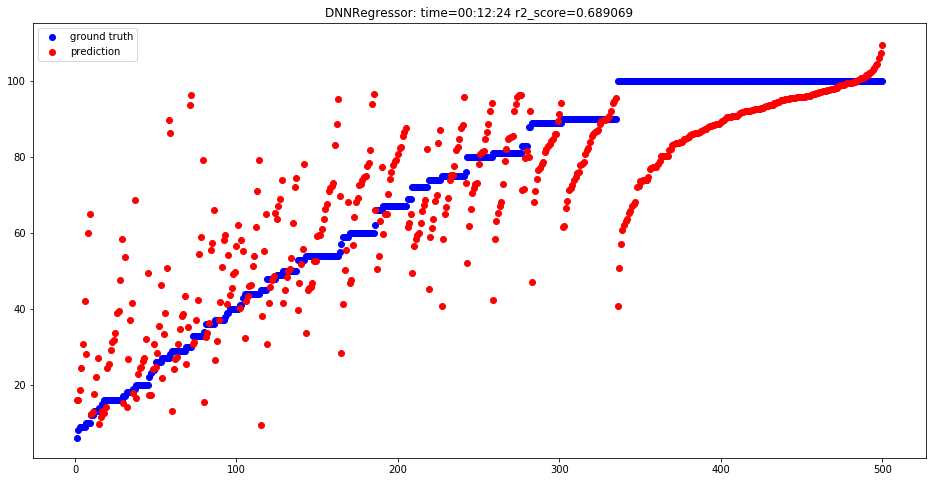

CPU times: user 11min 54s, sys: 1.9 s, total: 11min 56s
Wall time: 12min 25s


In [4]:
%%time
# create a validation monitor
validation_metrics = {
    "accuracy":
        tensorflow.contrib.learn.MetricSpec(
        metric_fn=tensorflow.contrib.metrics.streaming_accuracy,
#        prediction_key="classes"),
        prediction_key="scores"
        ),
    "precision":
        tensorflow.contrib.learn.MetricSpec(
        metric_fn=tensorflow.contrib.metrics.streaming_precision,
#        prediction_key="classes"),
        prediction_key="scores"
        ),
    "recall":
        tensorflow.contrib.learn.MetricSpec(
        metric_fn=tensorflow.contrib.metrics.streaming_recall,
#        prediction_key="classes"),
        prediction_key="scores"
        ),
}

validation_monitor = tensorflow.contrib.learn.monitors.ValidationMonitor(
      x_test,
      y_test,
      every_n_steps = 50,
      metrics = validation_metrics,
      early_stopping_metric_minimize = True,
      early_stopping_rounds = 200,
      early_stopping_metric = "accuracy",  #"loss",
)

# create DNN regressor
algo_name = 'DNNRegressor'
feature_columns = learn.infer_real_valued_columns_from_input(x_train)

regressor = learn.DNNRegressor(
    feature_columns = feature_columns, 
    hidden_units = [400, 200, 100], 
    model_dir = "/data/tmp/tf/tb/dnnr",
    )

# begin train
tstart = time.time()
regressor.fit(
    x = x_train, 
    y = y_train,
    steps = 2000,
    # limit batch_size, or dimension of gradient tensor too large !!!
    batch_size = x_train.shape[0] / 10, 
    monitors = [validation_monitor]
    )

y_predicted = regressor.predict(x = x_test, as_iterable = False)
score = metrics.r2_score(y_test, y_predicted)
score = 'r2_score={0:f}'.format(score)
tend = time.time()

tsec = tend - tstart
tmin = tsec // 60
tsec = tsec %  60
thrs = tmin // 60
tmin = tmin %  60
tuse = 'time=%02d:%02d:%02d' % (thrs, tmin, tsec)

# sort to make plot look not so fuzzy
# intact y_test & y_predicted for next iteration or algorithm!!!
p_test, p_predicted = zip(*sorted(zip(y_test, y_predicted)))

fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
plt.scatter(numpy.arange(1, x_test.shape[0]+1, 1), p_test,      c='b', label='ground truth') 
plt.scatter(numpy.arange(1, x_test.shape[0]+1, 1), p_predicted, c='r', label='prediction')                                                                                                  
plt.axis('tight')                                                                                                                           
plt.legend()                                                                                                                                
plt.title("%s: %s %s" % (algo_name, tuse, score))                                                                                                                                      
plt.show()                                                                                                                                      
plt.savefig("/data/tmp/%s.png" % algo_name) 


Nvidia K80 GPU shortens the execution time of this script from 58:37 to 12:24. It is x5 speedup.

From console log of jupyter notebook below, the execution of this script did use GPU:

[I 01:47:16.096 NotebookApp] Adapting to protocol v5.1 for kernel 50c0e466-09a2-4eb1-8379-d797a52297eb

I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcublas.so.7.5 locally

I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcudnn.so.5 locally

I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcufft.so.7.5 locally

I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcuda.so.1 locally

I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcurand.so.7.5 locally

I tensorflow/core/common_runtime/gpu/gpu_device.cc:885] Found device 0 with properties: 

name: Tesla K80

major: 3 minor: 7 memoryClockRate (GHz) 0.8235

pciBusID 0000:00:1e.0

Total memory: 11.17GiB

Free memory: 11.11GiB

I tensorflow/core/common_runtime/gpu/gpu_device.cc:906] DMA: 0 

I tensorflow/core/common_runtime/gpu/gpu_device.cc:916] 0:   Y 

[I 01:49:15.581 NotebookApp] Saving file at /dnnr.ipynb

I tensorflow/core/common_runtime/gpu/gpu_device.cc:975] Creating TensorFlow device (/gpu:0) -> (device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0)

[I 01:51:15.539 NotebookApp] Saving file at /dnnr.ipynb
